<a href="https://www.kaggle.com/code/gizemnalbantarslan/sentiment-analysis-w-amazon-dataset?scriptVersionId=199071379" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <span style="color:lime;"> About Me </span>

Hello. I am Gizem Nalbant Arslan, a data scientist who loves to draw insights using the power of data and is always ready to explore new horizons in the world of machine learning.

After graduating from Industrial Engineering, I joined the continuous improvement department in the automotive industry. Leading projects here allowed me to discover my passion for data science, and I embarked on a fresh start in my career. Your support along this journey means a lot to me.

You can reach my [LinkedIn](http://https://www.linkedin.com/in/gizem-nalbant-arslan/) profile. 🔗

I look forward to meeting you.

Skills:

* Data Science 📊
* SQL 🗄️
* Python 🐍
* Machine Learning 🤖
* Statistical Models 📈

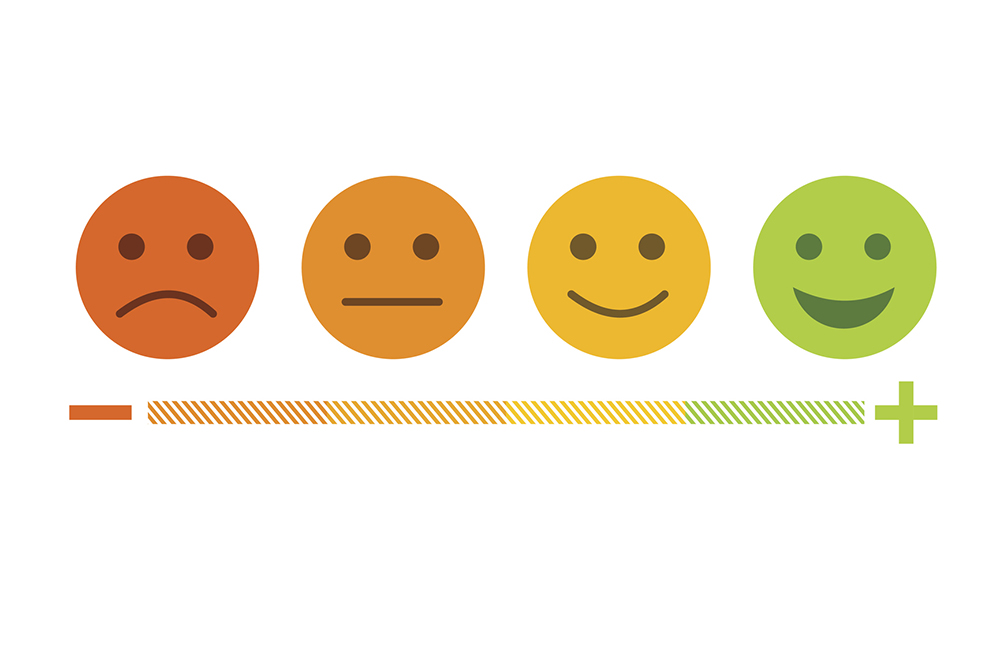

# ABOUT DATASET

📌 Kozmos, which makes home textile and daily wear-oriented productions that sell through Amazon, aims to increase its sales by analyzing the comments on its products and improving its features according to the complaints it receives. In line with this goal, the comments will be labeled with sentiment analysis and a classification model will be created with the labeled data.

📌 The data set consists of variables indicating the reviews of a particular product group, the title of the review, the number of stars and how many people found the review useful.
    
* Star : Number of stars for the product
* HelpFul :Number of people who found the comment useful
* Title: Title given to the comment content, short comment
* Review: Product review

# Import

In [ ]:
!pip install nltk
!pip install textblob
!pip install wordcloud

from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
df = pd.read_excel("/kaggle/input/amazon-reviews/amazon.xlsx")
df.head()

In [ ]:
# Normalizing Case Folding
df['Review'] = df['Review'].str.lower()

# Punctuations
df['Review'] = df['Review'].str.replace('[^\w\s]', '')

# regular expression
# Numbers
df['Review'] = df['Review'].str.replace('\d', '')

In [ ]:
import nltk

sw = stopwords.words('english')

df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))


In [ ]:
# Rarewords
temp_df = pd.Series(' '.join(df['Review']).split()).value_counts()

drops = temp_df[temp_df <= 1]

df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))


In [ ]:
# Lemmatization
df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))


# Data Visualization

In [ ]:
tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

tf.columns = ["words", "tf"]

tf.sort_values("tf", ascending=False)

In [ ]:
#Wordcloud
text = " ".join(i for i in df.Review)

wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Sentiment Analysis

In [ ]:
df["Review"].head()

In [ ]:
sia = SentimentIntensityAnalyzer()
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x))

In [ ]:
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

In [ ]:
df["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

In [ ]:
pol_ = pd.concat([df["Review"][0:10], df["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")], axis=1)
pol_.columns = ["Review", "Polarity Scores"]
pol_

In [ ]:
df["sentiment_label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
df["sentiment_label"].value_counts()

In [ ]:
df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])

In [ ]:
y = df["sentiment_label"]
X = df["Review"]

In [ ]:
# Count Vector
vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(X)

In [ ]:
X_count.toarray()[10:15]

In [ ]:
# TF-IDF
tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)

In [ ]:
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 3))
X_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(X)

# Modeling

# Logistic Regression

In [ ]:
# Words with TF-IDF
log_model = LogisticRegression().fit(X_tf_idf_word, y)
cross_val_score(log_model,
                X_tf_idf_word,
                y,
                scoring="accuracy",
                cv=5).mean()

In [ ]:
sample = df["Review"].sample(1).values
print(sample)
random_review = pd.Series(sample)
new_review = TfidfVectorizer().fit(X).transform(random_review)
log_model.predict(new_review)

# Random Forests

In [ ]:
# TF-IDF Word-Level
rf_model = RandomForestClassifier().fit(X_tf_idf_word, y)
cross_val_score(rf_model, X_tf_idf_word, y, cv=5, n_jobs=-1).mean()

# Hyperparameter Optimization

In [ ]:
rf_model = RandomForestClassifier(random_state=17)

In [ ]:
rf_params = {"max_depth": [8, None],
             "max_features": [7, "sqrt"],
             "min_samples_split": [2, 5, 8],
             "n_estimators": [100, 200]}

In [ ]:
rf_best_grid = GridSearchCV(rf_model,
                            rf_params,
                            cv=5,
                            n_jobs=-1,
                            verbose=1).fit(X_count, y)

In [ ]:
rf_best_grid.best_params_

# Final Model

In [ ]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X_count, y)

In [ ]:
cross_val_score(rf_final, X_count, y, cv=5, n_jobs=-1).mean()